# SD701
## Lab on real-world graph analysis

The objective of this lab is to get a feeling of real-world graphs. For information on the `scikit-network` library, [the documentation is handy](https://scikit-network.readthedocs.io/).

## Import

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from itertools import groupby

In [3]:
import sknetwork as skn

In [4]:
# Util function to plot the inverse cumulative distribution
def ccdf(values):
    x = []
    y = []
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]

    # Then compute inverse cumulative
    total = 1.0
    for (val, count) in dist:
        x.append(val)
        y.append(total)
        total -= count/len(values)
    return x, y

# Util function to return the distribution of values
def dist(values):
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]
    
    return [x[0] for x in dist], [x[1] for x in dist]

## Load data

We will work on 2 graphs induced by the [Vital articles of Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4), a selection of about 10,000 articles of the English Wikipedia:
* the directed graph of hyperlinks between these articles,
* the bipartite graph between articles and (stemmed) words used in their summary.

In [5]:
data = skn.data.load_netset('wikivitals')
data.keys()

Parsing files...
Done.


dict_keys(['adjacency', 'biadjacency', 'labels', 'labels_hierarchy', 'meta', 'names', 'names_col', 'names_labels', 'names_labels_hierarchy'])

In [6]:
# graph of links
adjacency = data.adjacency

In [7]:
# graph of words
biadjacency = data.biadjacency

In [8]:
# article names
names = data.names

In [9]:
# article categories
categories = data.names_labels
categories

array(['Arts', 'Biological and health sciences', 'Everyday life',
       'Geography', 'History', 'Mathematics', 'People',
       'Philosophy and religion', 'Physical sciences',
       'Society and social sciences', 'Technology'], dtype='<U30')

In [10]:
# words
words = data.names_col
words

array(['Alexis', 'Cairo', 'subordinate', ..., 'parody', 'martyrdom',
       'Wyler'], dtype='<U26')

In [11]:
node_index = {name:i for i, name in enumerate(names)}

In [12]:
n_articles, n_words = biadjacency.shape

In [13]:
labels = data.labels

In [14]:
num_articles = biadjacency.shape[0]
num_words = biadjacency.shape[1]
print(f"There are {num_articles} articles in the words graph, and {num_words} words, so that's a total of {num_articles+num_words} nodes.")

There are 10011 articles in the words graph, and 37845 words, so that's a total of 47856 nodes.


In [15]:
print(f"There are {adjacency.nnz} edges in the article graph.")
print(f"There are {biadjacency.nnz} edges in the words graph.")

There are 824999 edges in the article graph.
There are 1363301 edges in the words graph.


We know that in the adjacency matrix, the presence of an edge between nodes i and j corresponds to a 1 in the matrix at coordinates (i,j). So, if we count the number of $1$'s in row i, we obtain the number of neighbours of node i (i.e. its degree).
To do this efficiently for all nodes, we compute the matrix product between `adjacency` and an adequately sized vector of $1$'s.

In [16]:
degrees = np.array(adjacency.dot(np.ones(adjacency.shape[0])))

In [17]:
min(degrees), max(degrees), np.mean(degrees)

(0.0, 680.0, 82.40924982519229)

Let us now look at the degree distribution. We use the helper functions `dist` and `ccdf` (for **C**umulative **C**onverse **D**istribution **F**unction)

Text(0, 0.5, 'Number of words having degree = k')

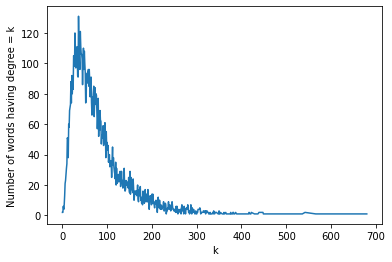

In [18]:
import matplotlib.pyplot as plt

degree_dist_x, degree_dist_y = dist(degrees)

plt.plot(degree_dist_x, degree_dist_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree = k")

This distributions are interesting, but somewhat "noisy", which can make them hard to read. It is sometimes useful to look isntead at the Inverse Cumulative Distribution, that is usually much smoother.

Text(0, 0.5, 'Number of words having degree >= k')

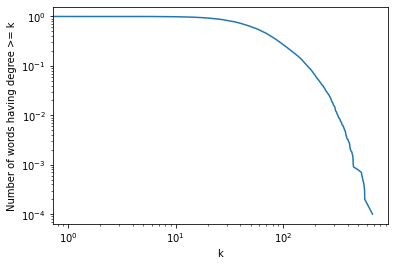

In [19]:
degree_ccdf_x, degree_ccdf_y = ccdf(degrees)

plt.loglog(degree_ccdf_x, degree_ccdf_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree >= k")

Let us do the same for the biadjacency matrix. We use the same "trick", however notice that there are two types of nodes (the matrix is not square anymore), so we have to separate the degrees of the articles and the words.

In [20]:
biadj_articles_degrees = np.array(biadjacency.T.dot(np.ones(biadjacency.shape[0])))
biadj_words_degrees = np.array(biadjacency.dot(np.ones(biadjacency.shape[1])))

In [21]:
print("Articles:", min(biadj_articles_degrees), max(biadj_articles_degrees), np.mean(biadj_articles_degrees))
print("Words:", min(biadj_words_degrees), max(biadj_words_degrees), np.mean(biadj_words_degrees))

Articles: 2.0 206697.0 70.28363059849386
Words: 14.0 1114.0 265.69613425232245


Text(0, 0.5, 'Number of articles having degree = k')

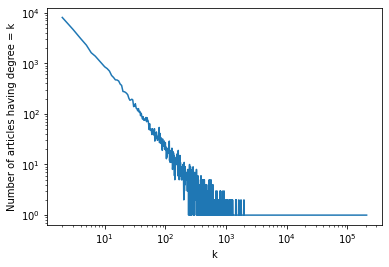

In [22]:
degree_articles_dist_x, degree_articles_dist_y = dist(biadj_articles_degrees)
degree_words_dist_x, degree_words_dist_y = dist(biadj_words_degrees)

plt.loglog(degree_articles_dist_x, degree_articles_dist_y)
plt.xlabel("k")
plt.ylabel("Number of articles having degree = k")

Text(0, 0.5, 'Number of words having degree = k')

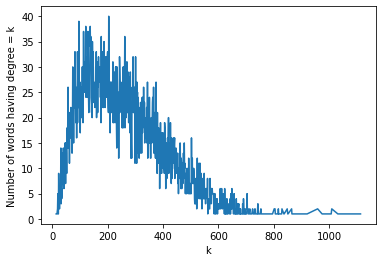

In [23]:
plt.plot(degree_words_dist_x, degree_words_dist_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree = k")

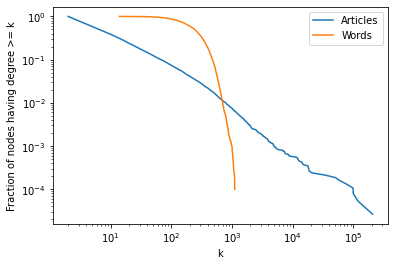

In [24]:
degree_articles_ccdf_x, degree_articles_ccdf_y = ccdf(biadj_articles_degrees)
degree_words_ccdf_x, degree_words_ccdf_y = ccdf(biadj_words_degrees)


plt.loglog(degree_articles_ccdf_x, degree_articles_ccdf_y, label="Articles")
plt.loglog(degree_words_ccdf_x, degree_words_ccdf_y, label="Words")
plt.xlabel("k")
plt.ylabel("Fraction of nodes having degree >= k")
plt.legend()

# Spectral embeddings

First, let us compute spectral embeddings. You can use the documentation for `scikit-network` : https://scikit-network.readthedocs.io/en/latest/tutorials/embedding/spectral.html

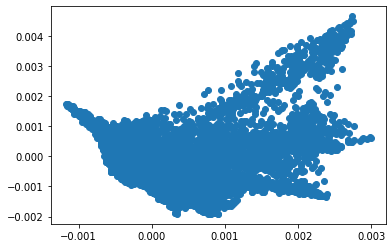

In [25]:
from IPython.display import SVG
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.embedding import Spectral
import matplotlib.pyplot as plt

spectral = Spectral(2)
embedding_spectral = spectral.fit_transform(adjacency)
plt.scatter(embedding_spectral[:,0], embedding_spectral[:,1])
plt.show()

Do the same with SVD embeddings (https://scikit-network.readthedocs.io/en/latest/tutorials/embedding/svd.html). Are the results very different?

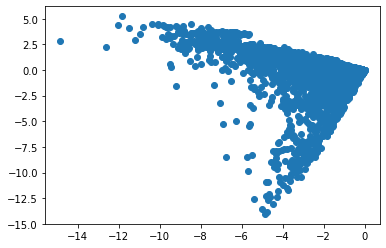

In [26]:
from scipy.spatial.distance import euclidean
from sknetwork.embedding import SVD

svd = SVD(2)
embedding_svd = svd.fit_transform(adjacency)
plt.scatter(embedding_svd[:,0], embedding_svd[:,1])
plt.show()

Using (for example) `scikit-learn`'s $k$-means algorithm, cluster your embeddings. What sense can you make of the clusters? For example, are they comparable to the ones obtained with the Louvain algorithm?

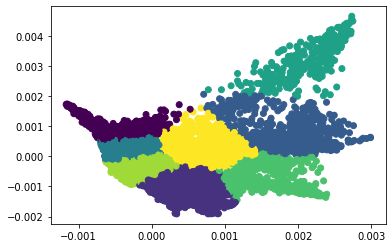

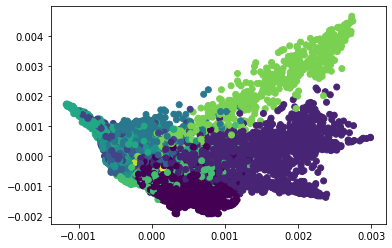

0.4492080677272827

In [27]:
from sklearn.cluster import KMeans
from sknetwork.clustering import Louvain
from sklearn.metrics import v_measure_score

kmpred = KMeans().fit(embedding_spectral).labels_
louvainpred = Louvain().fit_transform(adjacency)

plt.scatter(embedding_spectral[:,0], embedding_spectral[:,1], c=kmpred)
plt.show()

plt.scatter(embedding_spectral[:,0], embedding_spectral[:,1], c=louvainpred)
plt.show()

v_measure_score(kmpred, louvainpred)

# DeepWalk and node2vec

Let us compare to `node2vec` embeddings. Unfortunately, `Deepwalk` and `node2vec` are not yet in `scikit-network`. You can install the `nodevectors` python package, available here: https://github.com/VHRanger/nodevectors and on `pip`. `nodevectors` accepts CSR matrices as input, so you should not need much data manipulation.

In [28]:
#!pip install nodevectors

How are the clusters different when playing with the $p$ and $q$ parameters? Can you find a combination $(p,q)$ that gives similar results to the spectral embedding?

In [29]:
from nodevectors import Node2Vec

#Node2Vec?

g2v = Node2Vec(n_components=2, return_weight=.5, neighbor_weight=.5)
preds = g2v.fit_transform(G=adjacency)

Making walks... Done, T=410.18
Mapping Walk Names... Done, T=5.92
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


C:\Users\phile\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


KeyboardInterrupt: 